In [1]:
%matplotlib inline

In [2]:
from uwnet.stochastic_parameterization import utils
from src.data import open_data
import xarray as xr
import numpy as np

/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
ds = open_data('training')
base_model = '../models/268/5.pkl'



ds = utils.insert_nn_output_precip_ratio_bin_membership(ds, utils.default_binning_quantiles, base_model,
                                                        binning_method='column_integrated_qt_residuals')

/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'uwnet.normalization.Scaler' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.ParameterDict' has changed. you can retrieve the or

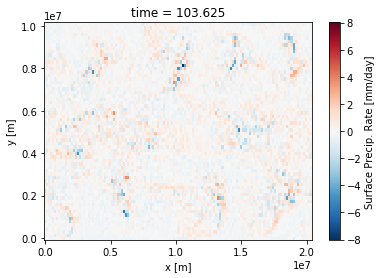

In [4]:
ds.column_integrated_qt_residuals[24].plot()

In [5]:
def one_hot(arr):
    m = int(arr.min())
    M = int(arr.max())
    return xr.concat([arr == m for m in range(m, M+1)], dim='bin')

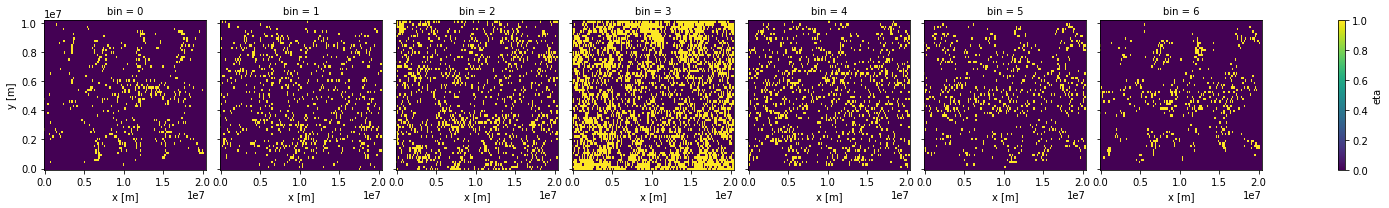

In [6]:
one_hot(ds.eta[0]).plot(col='bin')

In [7]:
eta = ds.eta.isel(time=slice(0, 100)).astype(int)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def conditional_distribution(eta, window=3):
    rol = eta.rolling(time=window).construct('window').dropna('time').stack(sample=['time', 'y', 'x'])
    df = pd.DataFrame(rol.values.T).astype(int)    
    tab =  pd.crosstab([df[i] for i in range(df.shape[-1]-1)], df.iloc[:,-1])
    
    sum_eta = tab.sum(axis=1)
    return tab.apply(lambda x: x/sum_eta)

def plot_conditional_distributions(tab):
    fig, axs = plt.subplots(3, 3, figsize=(10,10), constrained_layout=True)


    for i in range(7):
        ax = axs.ravel()[i]
        sns.heatmap(tab.loc[i]*100, ax=ax, annot=True, fmt=".0f", cbar=False, vmin=0, vmax=60)
        ax.set_title(f'eta0 = {i}')
        ax.set_xlabel('eta2')
        ax.set_ylabel('eta1')
        ax.invert_yaxis()

Let's show the different $(p(\eta_n|\eta_{n-1}, \eta_{n-2})$ distributions:

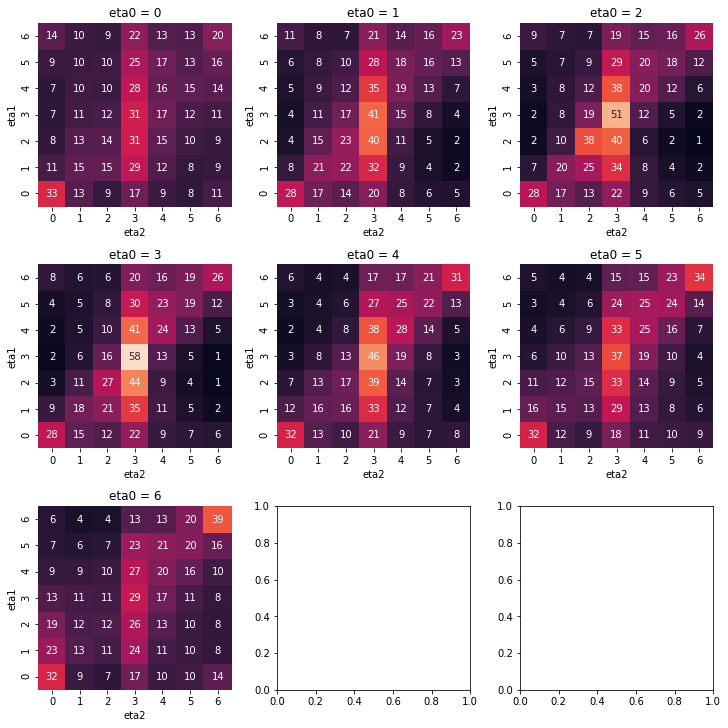

In [9]:
tab = conditional_distribution(eta, window=3)
plot_conditional_distributions(tab)

The numbers written in these heatmaps are the propbability in percent. The rows in each panel sum to 100.

This reveals a couple of things.
1. $\eta$ process is not Markov (at least without additional inputs, e.g. PW). If the process is Markov, then each of these panels should be the same, which is not the case.
2. The process will tend to switch into the middle bin ($\eta$=3) with very high probability in a 3 hour time step.

Does adding state dependence resolve this non-markovianity? To answer this, we can fit logistic regression models which include 2 time steps of $\eta$, and 1, and see if they give different answers.

In [10]:
tropics = ds.sel(y=slice(4.5e6, 5.5e6))

In [11]:
def get_ins_outs(ds, past=2, stride=50):
    ds = ds.assign(PW=(ds.QT * ds.layer_mass).sum('z')/1000)

    input_vars = ['PW', 'SOLIN', 'SST', 'eta']
    windowed_data = ds[input_vars]\
          .rolling(time=past+1)\
          .construct('window', stride=stride)\
          .dropna('time')\
          .stack(sample=['time', 'y', 'x'])

    y = windowed_data.eta[-1]
    X = windowed_data.isel(window=slice(0, -1))

    X['eta'] = one_hot(X.eta)

    X = X.to_stacked_array('feature', ['bin', 'window'])
    
    return X, y

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [13]:
def predict_proba(ds, past=2):
    X,y = get_ins_outs(tropics, past=past)
    print(past)
    reg = LogisticRegression(multi_class='auto', solver='liblinear').fit(X, y)
#     reg = RandomForestClassifier(n_estimators=100).fit(X, y)
    return xr.DataArray(reg.predict_proba(X), dims=['sample', 'eta'], coords=y.coords)


def predict_probas(ds, pasts):
    probas = [predict_proba(tropics, past=i) for i in pasts]
    return xr.concat([prob.unstack('sample') for prob in probas], dim=pd.Index(pasts, name='past')).dropna('time')

In [14]:
probas = predict_probas(tropics, [1, 2, 4, 5, 8, 10, 20])

1
2
4
5
8
10
20


In [15]:
p_eq = np.bincount(tropics.eta.values.ravel())
p_eq = xr.DataArray(p_eq / np.sum(p_eq), dims='eta')

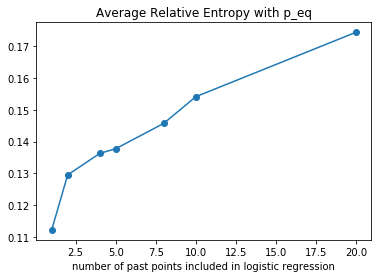

In [16]:
H = (p_eq * np.log(p_eq/(probas+.0000001))).sum('eta').mean(['x', 'y', 'time'])

H.plot(marker='o')
plt.xlabel('number of past points included in logistic regression')
plt.title('Average Relative Entropy with p_eq');

This shows that the NN is gaining information compared to the equilibrium distribution by including more points. This suggests that including state-dependence does not help much with the markovianity.

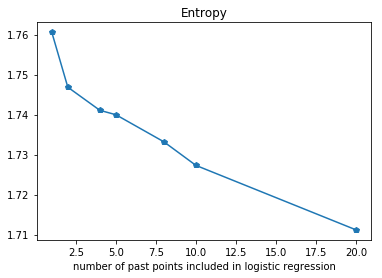

In [17]:
H = -(probas * np.log(probas)).sum('eta').mean(['x', 'y', 'time'])
H.plot(marker='p')
plt.xlabel('number of past points included in logistic regression')
plt.title('Entropy');

The average entropy is decreasing, indicating that the extra information is reducing the uncertainty in the prediction.